In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk
#nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')  
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data csv file
reviews_df = pd.read_csv('sample30.csv')

In [3]:
# Check the dataset
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [4]:
#Check the shape of dataset
reviews_df.shape

(30000, 15)

In [5]:
#Check Info of the dataset
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
## DATA CLEANING

In [7]:
# Check for the Null values
reviews_df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

# ### Observation: 'reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince' columns contains majority of the null values and those columns are not useful for the Analysis.

In [8]:
#Drop 'reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince' columns
reviews_df.drop(['reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince'],axis=1,inplace=True)

In [9]:
# Check Null values again
reviews_df.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            1
dtype: int64

In [10]:
# Check reviews_doRecommend column data
reviews_df.reviews_doRecommend.value_counts()

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

# #### Observation: Majority of the 'True' values exists in the 'reviews_doRecommend' columns. So, not useful for modeling

In [11]:
# Drop reviews_doRecommend column
reviews_df.drop(['reviews_doRecommend'],axis=1,inplace=True)

In [12]:
# Check Null values again
reviews_df.isnull().sum()

id                    0
brand                 0
categories            0
manufacturer        141
name                  0
reviews_date         46
reviews_rating        0
reviews_text          0
reviews_title       190
reviews_username     63
user_sentiment        1
dtype: int64

In [13]:
# Check for the Null values in the user_sentiment column
reviews_df[reviews_df.user_sentiment.isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [14]:
# Since, we only found one row lets fill it manually
print("Review Text :")
print(list(reviews_df[reviews_df.user_sentiment.isna()]['reviews_text'])[0], )
print("Review Title : ")
print(list(reviews_df[reviews_df.user_sentiment.isna()]['reviews_title'])[0])

Review Text :
my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy
Review Title : 
a super hit with my children. they loved it!!??


In [15]:
# Update the user_sentiment for missing value
reviews_df.user_sentiment.fillna('Positive',inplace=True)

In [16]:
# Check for the Null values again
reviews_df.isnull().sum()

id                    0
brand                 0
categories            0
manufacturer        141
name                  0
reviews_date         46
reviews_rating        0
reviews_text          0
reviews_title       190
reviews_username     63
user_sentiment        0
dtype: int64

In [17]:
# Drop rows where reviews_title contains null values
reviews_df_clean = reviews_df[~reviews_df.reviews_title.isna()]
# Drop rows where reviews_username contains null values 
reviews_df_clean = reviews_df_clean[~reviews_df_clean.reviews_username.isna()]

In [18]:
# Drop categories, manufacturer & reviews_date columns as they are not useful for analysis
reviews_df_clean.drop(['categories','manufacturer','reviews_date'],axis=1,inplace=True)

In [19]:
# Check for the Null values again
reviews_df_clean.isnull().sum()

id                  0
brand               0
name                0
reviews_rating      0
reviews_text        0
reviews_title       0
reviews_username    0
user_sentiment      0
dtype: int64

In [20]:
#Check shape of the data
reviews_df_clean.shape

(29748, 8)

### Exploratory Data Analysis


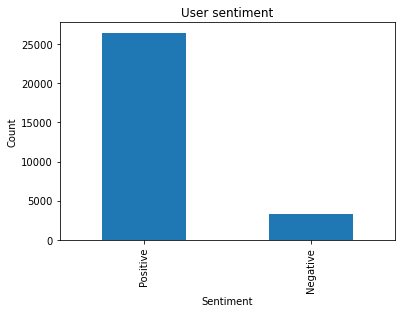

In [21]:
# Plot on user_sentiment 
reviews_df_clean['user_sentiment'].value_counts().plot(kind='bar')
plt.title("User sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Observation:From above figure , We observe that the data is highly imabalanced based on user sentiment.

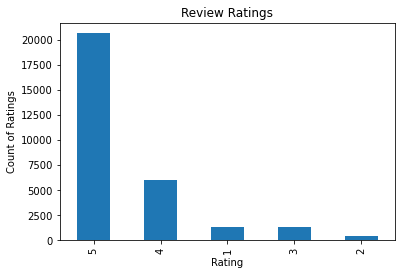

In [22]:
# Plot on reviews_rating 
reviews_df_clean['reviews_rating'].value_counts().plot(kind='bar')
plt.title("Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count of Ratings")
plt.show()

In [23]:
##Observation:From above figure , It is clear that most of the users given rating 5 followed by rating 4

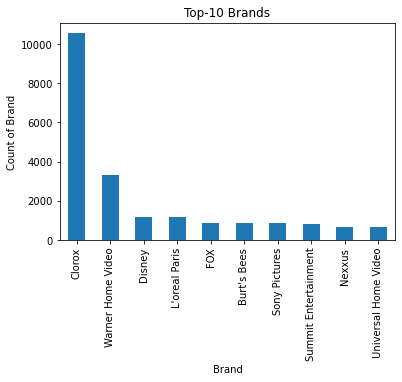

In [24]:
# Plot on Brands 
reviews_df_clean['brand'].value_counts()[:10].plot(kind='bar')
plt.title("Top-10 Brands")
plt.xlabel("Brand")
plt.ylabel("Count of Brand")
plt.show()

### Observation: From the above figure, We can observe that the Clorox is the brand which is purchased by most number of people.

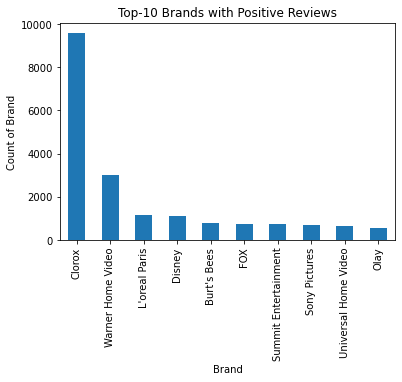

In [25]:
# Plot on Brands 
reviews_df_clean[reviews_df_clean.user_sentiment=='Positive']['brand'].value_counts()[:10].plot(kind='bar')
plt.title("Top-10 Brands with Positive Reviews")
plt.xlabel("Brand")
plt.ylabel("Count of Brand")
plt.show()

### Observation:From the above figure, It is clear that the Clorox brand having the highest number of positive reviews.

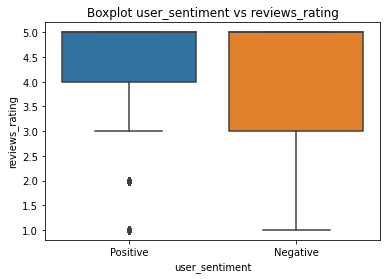

In [26]:
# Boxplot between the user_sentiment & review_rating
sns.boxplot(data = reviews_df_clean, x = 'user_sentiment', y = 'reviews_rating')
plt.xlabel('user_sentiment')
plt.ylabel('reviews_rating')
plt.title("Boxplot user_sentiment vs reviews_rating")
plt.show()

### Observation:From the above boxplot , We can see few outliers in positive reviews where ratings are given low.

### Pre-processing

In [27]:
# Create a copy of dataframe for pre-processing
df_pre = reviews_df_clean.copy()

In [28]:
# Combining reviews_text and reviews_title to make final_reviews
df_pre['final_review'] = df_pre['reviews_text']+" "+ df_pre['reviews_title']
#Drop reviews_text & reviews_title columns
df_pre.drop(['reviews_text','reviews_title'], axis=1, inplace=True)

In [29]:
# Converting all columns data types to string
for col in df_pre.columns:
    df_pre[col]=df_pre[col].astype(str)

In [30]:
# Create new sentiment_label to map categorical sentiment to integers
df_pre['sentiment_label'] = df_pre['user_sentiment'].map({"Positive":1,"Negative":0})

In [31]:
# Check shape of data
df_pre.shape

(29748, 8)

In [32]:
# Create new dataframe with required field for Sentiment Analysis
df_Sent_Ana = df_pre[['id','name','final_review','sentiment_label']]
df_Sent_Ana

,id,name,final_review,sentiment_label
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,1
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,1
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. Good,1
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,0
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,0
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,I got this conditioner with Influenster to try...,1
29996,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,"I love it , I received this for review purpose...",1
29997,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,First of all I love the smell of this product....,1
29998,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,I received this through Influenster and will n...,1


In [33]:
# Method to clean the text
def clean_text(text):
    #Convert text lowercase
    text=text.lower()
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    #Remove punctuation
    text=re.sub(r'[^\w\s]', '', text)
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_Sent_Ana['cleaned_reviews'] = df_Sent_Ana['final_review'].apply(clean_text)

In [34]:
#nltk.download('punkt')

# Method to remove stop words
def clean_stopwords(text):
    words = word_tokenize(text)
    text = " ".join([word for word in words if word not in stopwords_set])
    return text

df_Sent_Ana['cleaned_reviews'] = df_Sent_Ana['cleaned_reviews'].apply(clean_stopwords)
df_Sent_Ana

,id,name,final_review,sentiment_label,cleaned_reviews
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,1,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,1,good flavor review collected part promotion good
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. Good,1,good flavor good
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,0,read reviews looking buying one couples lubric...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,0,husband bought gel us gel caused irritation fe...
...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,I got this conditioner with Influenster to try...,1,got conditioner influenster try im loving far ...
29996,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,"I love it , I received this for review purpose...",1,love received review purposes influenster leav...
29997,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,First of all I love the smell of this product....,1,first love smell product wash hair smooth easy...
29998,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,I received this through Influenster and will n...,1,received influenster never go back anything el...


In [35]:
# Method to apply Lemmatization on text
def lammatize_text(text):
    lst = []
    doc = nlp(text)
    for word in doc:
        lst.append(word.lemma_)
    return " ".join(lst)

df_Sent_Ana['lemmatized_reviews'] = df_Sent_Ana['cleaned_reviews'].apply(lammatize_text)

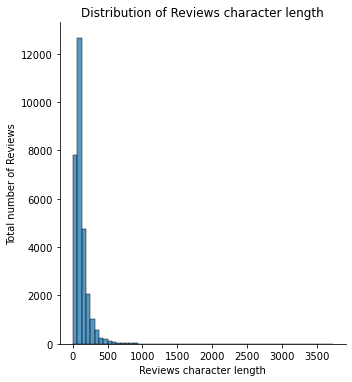

In [36]:
# Visualize 'reviews_lemmatized' character length
char_length = [len(each_sent) for each_sent in df_Sent_Ana['lemmatized_reviews']]

sns.displot(char_length, kind='hist', bins=60)
plt.xlabel("Reviews character length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of Reviews character length")
plt.show()

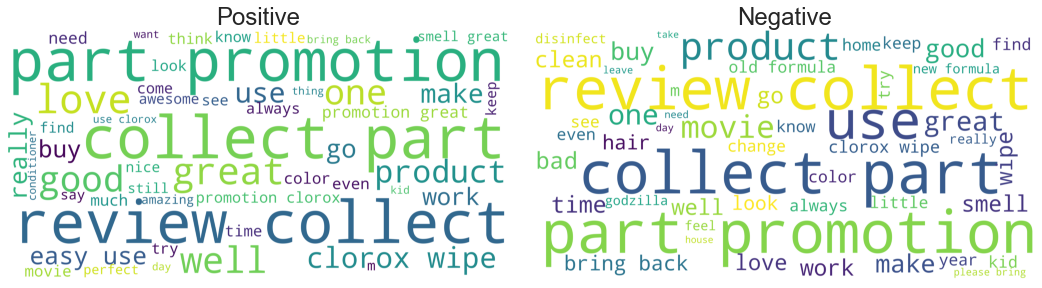

In [37]:
# Word clouds for postive and negative reviews 
sns.set(font_scale=2)
plt.figure(figsize = (15,10))

plt.subplot(1, 2, 1)
plt.title('Positive')
pos_reviews = df_Sent_Ana.loc[df_Sent_Ana.sentiment_label==1,['lemmatized_reviews']]
word_cloud_text = ''.join(pos_reviews['lemmatized_reviews'])
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white", 
                      scale = 10, width=800, height=400).generate(word_cloud_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()


plt.subplot(1, 2, 2)
plt.title('Negative')
neg_reviews = df_Sent_Ana.loc[df_Sent_Ana.sentiment_label==0,['lemmatized_reviews']]
word_cloud_text = ''.join(neg_reviews['lemmatized_reviews'])
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white",
                      scale = 10, width=800, height=400).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()

### Feature Extraction

In [38]:
# Tfidf vectorization
tf_idf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english')
X = tf_idf.fit_transform(df_Sent_Ana['lemmatized_reviews'])
y = df_Sent_Ana['sentiment_label']

In [39]:
# split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)


In [40]:
print("Train shapes:", X_train.shape)
print("Test shapes:", X_test.shape)


Train shapes: (23798, 4275)
Test shapes: (5950, 4275)


In [41]:
#Check user_sentiment column
df_Sent_Ana['sentiment_label'].value_counts(normalize=True)

1    0.887892
0    0.112108
Name: sentiment_label, dtype: float64

#### Handle Class Imbalance

In [42]:
# Perform Class-balancing using SMOTE
counter = Counter(y_train)
print("Before class imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)

#counter = Counter(y_train_sm)
print("After class imbalance", counter)


Before class imbalance Counter({1: 21098, 0: 2700})
After class imbalance Counter({1: 21098, 0: 2700})


In [43]:
type(X_train_balanced)

scipy.sparse._csr.csr_matrix

#### Model Building

In [44]:
# Creating a common fuction which is usable to print the accuracy metrics of different models
def evaluation_metrics(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    
    # Confusion matrix
    confusion = confusion_matrix(actual, pred)
   
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    # Calculating Sensitivity/Recall
    sensitivity_recall = (TP / float(TP + FN))
    sensitivity_recall = round(sensitivity_recall,2)
  
    # Calculating Specificity
    specificity = (TN / float(TN + FP))
    specificity = round(specificity,2)  
  
    # Calculating Precision
    precision = (TN / float(TN + FP))
    precision = round(precision,2)  
    
    # Calculating F_1 score
    f1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
    f1_score = round(f1_score,2)  
    
    return pd.DataFrame([{"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Recall":sensitivity_recall,"Precision":precision,"Specificity":specificity,"F1-Score":f1_score,"Accuracy":acc_score}])


#### Model-1: Logistic Regression 

In [45]:
# Base Model
lg_model = LogisticRegression(random_state=42,solver='liblinear')
lg_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(random_state=42, solver='liblinear')

In [46]:
# Predict the train data
Y_train_pred = lg_model.predict(X_train_balanced)
# Predict the test data
Y_test_pred = lg_model.predict(X_test)

In [47]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,18399,19701,1397,2699,0.87,0.93,0.93,0.90,90.29
test_data,4509,496,139,806,0.85,0.78,0.78,0.81,84.12


In [48]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
   
    }
]

In [49]:
lg_tune_model = GridSearchCV(lg_model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_lg_tune_model = lg_tune_model.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


In [50]:
# Predict the train data
Y_train_pred = lg_tune_model.predict(X_train_balanced)
# Predict the test data
Y_test_pred = lg_tune_model.predict(X_test)

In [51]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,19695,20493,605,1403,0.93,0.97,0.97,0.95,95.24
test_data,4649,392,243,666,0.87,0.62,0.62,0.72,84.72


### Model-2: Random Forest

In [52]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [53]:
# Predict the train data
Y_train_pred = rf.predict(X_train_balanced)
# Predict the test data
Y_test_pred = rf.predict(X_test)

In [54]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,21097,21093,5,1,1.00,1.00,1.00,1.00,99.99
test_data,5050,309,326,265,0.95,0.49,0.49,0.65,90.07


In [55]:
param_grid = {
    'max_depth': [10,20,30],
    'min_samples_leaf': [100,125,150,175],
    'min_samples_split': [200,250,300],
    'n_estimators': [250,350,500], 
    'max_features': [10,15]
}

In [56]:
# Create a based model
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, scoring="recall", n_jobs = -1,verbose = 1)

In [57]:
# Fit the grid search to the data
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'max_features': [10, 15],
                         'min_samples_leaf': [100, 125, 150, 175],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [250, 350, 500]},
             scoring='recall', verbose=1)

In [58]:
# printing the optimal accuracy score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

We can get recall of 0.8544886461090494 using {'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 100, 'min_samples_split': 300, 'n_estimators': 350}


In [59]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=125, 
                             min_samples_split=250,
                             max_features=10,
                             n_estimators=500)

In [60]:
# fit
rfc.fit(X_train_balanced, y_train_balanced)

Y_train_pred = rfc.predict(X_train_balanced)
Y_test_pred = rfc.predict(X_test)

In [61]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,17651,14456,6642,3447,0.84,0.69,0.69,0.76,76.09
test_data,4464,308,327,851,0.84,0.49,0.49,0.62,80.20


### Model-3: Xgboost

In [62]:
xgboost = XGBClassifier(random_state=42)
xgboost.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [63]:
# Predict the train data
Y_train_pred = xgboost.predict(X_train_balanced)
# Predict the test data
Y_test_pred = xgboost.predict(X_test)

In [64]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,19899,19714,1384,1199,0.94,0.93,0.93,0.93,93.88
test_data,4840,360,275,475,0.91,0.57,0.57,0.70,87.39


In [65]:
param_grid = { 
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    "reg_alpha": [0, 0.5, 1, 5],
    "reg_lambda": [0, 0.5, 1, 5],
    "learning_rate": [0.45, 0.15],
    "max_depth": [5, 10]
           
    }

In [66]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
xgboost_tune_model = GridSearchCV(xgboost, param_grid = param_grid, cv = kfold, verbose=True, n_jobs=-1,scoring='f1')
best_xgboost_tune_model = xgboost_tune_model.fit(X_train_balanced, y_train_balanced)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [67]:
# Predict the train data
Y_train_pred = best_xgboost_tune_model.predict(X_train_balanced)
# Predict the test data
Y_test_pred = best_xgboost_tune_model.predict(X_test)

In [68]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val = pd.concat([train_val,test_val])
df_val['data'] = ['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,20750,20725,373,348,0.98,0.98,0.98,0.98,98.29
test_data,4970,349,286,345,0.94,0.55,0.55,0.69,89.39


#### Model-4: Naive Bayes

In [69]:
# instantiate the model
gnb = GaussianNB()
gnb.fit(X_train_balanced.todense(), y_train_balanced)

GaussianNB()

In [71]:
# Predict the train data
Y_train_pred = gnb.predict(X_train_balanced.todense())
# Predict the test data
Y_test_pred = gnb.predict(X_test.todense())

In [72]:
train_val = evaluation_metrics(y_train_balanced,Y_train_pred)
test_val = evaluation_metrics(y_test,Y_test_pred)
df_val=pd.concat([train_val,test_val])
df_val['data']=['train_data','test_data']
df_val.set_index('data',inplace=True)
df_val

,TP,TN,FP,FN,Recall,Precision,Specificity,F1-Score,Accuracy
data,,,,,,,,,
train_data,7353,21077,21,13745,0.35,1.00,1.00,0.52,67.38
test_data,1795,458,177,3520,0.34,0.72,0.72,0.46,37.87


### Observation:Out of the four models, Logistic Regression base model performed better on unseen(test) data. This model having better Precision, Recall and F1-scores compared other models even though they have high accuracies.

In [73]:
# Save model
filename = "logistic_base_model.pickle"
pickle.dump(lg_model, open(filename, "wb"))

### Building the Recommendation System

In [74]:
df_re_sys = pd.read_csv('sample30.csv')

In [75]:
# Select necessary columns which are required for the recommendation system
df_re_sys = df_re_sys[["id", "name", "reviews_rating", "reviews_username"]]

In [76]:
df_re_sys.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [77]:
# Check for the null values
df_re_sys.isnull().sum()

id                   0
name                 0
reviews_rating       0
reviews_username    63
dtype: int64

In [78]:
# Remove the rows which are having Username nulls
df_re_sys = df_re_sys[~df_re_sys.reviews_username.isna()]

In [79]:
# Check for the null values again
df_re_sys.isnull().sum()

id                  0
name                0
reviews_rating      0
reviews_username    0
dtype: int64

In [80]:
# Split the data into train and test
train, test = train_test_split(df_re_sys, test_size=0.20, random_state=42)

In [81]:
print("Train dataset shape:",train.shape)
print("Test dataset shape:",test.shape)

Train dataset shape: (23949, 4)
Test dataset shape: (5988, 4)


In [82]:
df_res_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_res_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# Copy the train dataset into copy_train
copy_train = train.copy()

In [84]:
# The products not rated by user is marked as 1 for prediction. 
copy_train['reviews_rating'] = copy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [85]:
# Convert the copy_train dataset into matrix format
copy_train = copy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

copy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
# Pivot the train ratings dataset into a matrix structure, with columns representing Items and rows representing usernames.
df_res_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [87]:
# Normalize the product ratings for each user to around 0 mean
mean = np.nanmean(df_res_pivot, axis=1)
df_subtract = (df_res_pivot.T-mean).T

In [88]:
df_subtract.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Using the pairwise distance function, creating the User Similarity Matrix
user_corr = 1 - pairwise_distances(df_subtract.fillna(0), metric='cosine')
user_corr[np.isnan(user_corr)] = 0
print(user_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [90]:
user_corr.shape

(20548, 20548)

In [91]:
# Prediction - User-User for positive reviews only
user_corr[user_corr<0] = 0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
user_pred_ratings = np.dot(user_corr, df_res_pivot.fillna(0))
user_pred_ratings

array([[0.        , 0.        , 2.5       , ..., 0.        , 1.83339699,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [93]:
user_pred_ratings.shape

(20548, 264)

In [94]:
user_fin_rating = np.multiply(user_pred_ratings,copy_train)
user_fin_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.697789,0.0,0.0,0.0,0.64226,2.620712,1.018079,...,0.0,0.0,0.0,0.0,0.0,0.0,1.462719,0.0,1.833397,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


### Top 20 products Recommendation based on user-to-user recommendation 

In [95]:
# Take a sample username as input.
user_input = '00sab00'

In [96]:
top_20_recomms = user_fin_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_20_recomms_df = pd.DataFrame({'Product Id': top_20_recomms.index, 'cosine_similarity_score' : top_20_recomms})
top_20_recomms_df.reset_index(drop=True, inplace=True)
top_20_recomms_df

,Product Id,cosine_similarity_score
0,AVpfPaoqLJeJML435Xk9,47.098791
1,AVpfRTh1ilAPnD_xYic2,36.741538
2,AVpf2tw1ilAPnD_xjflC,16.218225
3,AVpf0eb2LJeJML43EVSt,16.164427
4,AVpf3VOfilAPnD_xjpun,11.728031
5,AVpfR5m0LJeJML436K3W,11.259453
6,AVpfBrUZilAPnD_xTUly,9.054476
7,AVpf385g1cnluZ0-s0_t,6.980548
8,AVpfov9TLJeJML43A7B0,6.662164
9,AVpfJcHuLJeJML433ZrY,6.661900


In [97]:
top_20_rec = pd.merge(df_re_sys, top_20_recomms_df,left_on='id',right_on='Product Id', 
                     how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top_20_rec.reset_index(drop=True, inplace=True)
top_20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
15,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,47.098791
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,36.741538
4,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),16.218225
2,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),16.164427
6,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,11.728031
17,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,11.259453
9,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",9.054476
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",6.980548
14,AVpfov9TLJeJML43A7B0,Bisquick Original Pancake And Baking Mix - 40oz,6.662164
10,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),6.661900


### User-to-User Evaluation

In [98]:
# Find out the common users of train and test datasets
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

(1491, 4)

In [99]:
# convert into the user-product matrix.
common_user_prod_matrix = common_users.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [100]:
# Convert the user_correlation matrix into dataframe.
user_corr_df = pd.DataFrame(user_corr)

In [101]:
user_corr_df['userId'] = df_subtract.index
user_corr_df.set_index('userId',inplace=True)
user_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20538,20539,20540,20541,20542,20543,20544,20545,20546,20547
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
lst_name = common_users.reviews_username.tolist()

user_corr_df.columns = df_res_pivot.index.tolist()
user_corr_df_1 =  user_corr_df[user_corr_df.index.isin(lst_name)]
user_corr_df_2 = user_corr_df_1.T[user_corr_df_1.T.index.isin(lst_name)]
user_corr_df_3 = user_corr_df_2.T
user_corr_df_3.head()

,1234,1234567,123charlie,1witch,85lisa,a hutch,aac06002,aalyah,aaron,abcgator,...,wowiezowie,wren113,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zebras,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
user_corr_df_3[user_corr_df_3<0] = 0

common_user_pred_ratings = np.dot(user_corr_df_3, common_user_prod_matrix.fillna(0))
common_user_pred_ratings

array([[0.        , 1.44337567, 0.        , ..., 0.        , 0.        ,
        1.66666667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [104]:
# Creating copy test dataframe
copy_test = common_users.copy()

copy_test['reviews_rating'] = copy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

copy_test = copy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [105]:
common_user_pred_ratings = np.multiply(common_user_pred_ratings, copy_test)

In [106]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [107]:
common_users_ = common_users.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [108]:
# RMSE for User-to-User recommendation system
rmse_user_user = (sum(sum((common_users_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.535002250002317


## Item Based Similarity

In [109]:
df_res_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [110]:
# Normalizing the product rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_res_pivot, axis=1)
df_subtract = (df_res_pivot.T-mean).T

In [111]:
# Finding the cosine similarity using pairwise distances approach
# Item Similarity Matrix
item_corr = 1 - pairwise_distances(df_subtract.fillna(0), metric='cosine')
item_corr[np.isnan(item_corr)] = 0
print(item_corr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [112]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_corr[item_corr<0]=0
item_corr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [113]:
# Prediction - User-User for positive reviews only
item_pred_ratings = np.dot((df_res_pivot.fillna(0).T),item_corr)
item_pred_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.05942999,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0091844 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09904999,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00734752]])

In [114]:
# Filtering the rating only for the products not rated by the user for recommendation
item_fin_rating = np.multiply(item_pred_ratings, copy_train)
item_fin_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.008568,0.0,0.0,0.0,0.000000,0.000000,0.005666,...,0.000000,0.011946,0.0,0.0,0.0,0.018793,0.005351,0.0,0.05943,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.004493,...,0.072463,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.007489,...,0.120771,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.005991,...,0.096617,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001247,0.003517,0.001743,...,0.000000,0.003674,0.0,0.0,0.0,0.005780,0.000000,0.0,0.00000,0.009184


In [115]:
# Take a sample username as input.
user_input = '00sab00'

In [116]:
top_20_item_recomms = item_fin_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_20_item_recomms_df = pd.DataFrame({'Product Id': top_20_item_recomms.index, 'cosine_similarity_score' : top_20_item_recomms})
top_20_item_recomms_df.reset_index(drop=True, inplace=True)
top_20_item_recomms_df

,Product Id,cosine_similarity_score
0,AVpe7sl91cnluZ0-aI1Y,0.142864
1,AVpfE7puilAPnD_xUcCW,0.133706
2,AVpfRoqcLJeJML436FqG,0.114324
3,AVpfJcHuLJeJML433ZrY,0.061692
4,AVpfv4TlilAPnD_xhjNS,0.059430
5,AVpfNc9cLJeJML434tza,0.054446
6,AVpfOIrkilAPnD_xXgDG,0.034431
7,AVpf0thK1cnluZ0-r8vR,0.032949
8,AVpe_dxlilAPnD_xSiHI,0.031858
9,AVpe6PCDLJeJML43yFQH,0.029422


In [117]:
top_20_item_recomms = item_fin_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_20_item_recomms_df = pd.DataFrame({'Product Id': top_20_item_recomms.index, 'cosine_similarity_score' : top_20_item_recomms})
top_20_item_recomms_df.reset_index(drop=True, inplace=True)
top_20_item_recomms_df

,Product Id,cosine_similarity_score
0,AVpe7sl91cnluZ0-aI1Y,0.142864
1,AVpfE7puilAPnD_xUcCW,0.133706
2,AVpfRoqcLJeJML436FqG,0.114324
3,AVpfJcHuLJeJML433ZrY,0.061692
4,AVpfv4TlilAPnD_xhjNS,0.059430
5,AVpfNc9cLJeJML434tza,0.054446
6,AVpfOIrkilAPnD_xXgDG,0.034431
7,AVpf0thK1cnluZ0-r8vR,0.032949
8,AVpe_dxlilAPnD_xSiHI,0.031858
9,AVpe6PCDLJeJML43yFQH,0.029422


### Top 20 products Recommendation based on item-to-item recommendation

In [118]:
top_20_item_rec = pd.merge(df_re_sys, top_20_item_recomms_df,left_on='id',right_on='Product Id', 
                           how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top_20_item_rec.reset_index(drop=True, inplace=True)
top_20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
5,AVpe7sl91cnluZ0-aI1Y,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,0.142864
9,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.133706
17,AVpfRoqcLJeJML436FqG,"Vicks Vaporub, Regular, 3.53oz",0.114324
11,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.061692
19,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...,0.059430
12,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.054446
13,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.034431
7,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.032949
0,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.031858
4,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.029422


### Item-to-Item Evaluation

In [119]:
# Find out the common products of test and train dataset.
common_prod = test[test.id.isin(train.id)]
common_prod.shape

(5980, 4)

In [120]:
common_item_based_matrix = common_prod.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
item_corr_df = pd.DataFrame(item_corr)
item_corr_df['movieId'] = df_subtract.index
item_corr_df.set_index('movieId',inplace=True)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
movieId,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
lst_name = common_prod.id.tolist()

In [122]:
item_corr_df.columns = df_subtract.index.tolist()

item_corr_df_1 =  item_corr_df[item_corr_df.index.isin(lst_name)]
item_corr_df_2 = item_corr_df_1.T[item_corr_df_1.T.index.isin(lst_name)]
item_corr_df_3 = item_corr_df_2.T
item_corr_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
movieId,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002316,0.0,0.0,...,0.000000,0.097694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.101523,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
item_corr_df_3[item_corr_df_3<0]=0

common_item_pred_ratings = np.dot(item_corr_df_3, common_item_based_matrix.fillna(0))
common_item_pred_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01862395, 3.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00734752, ..., 0.        , 0.        ,
        0.0091844 ]])

In [124]:
# Copy test will be used for evaluation
copy_test = common_prod.copy()

copy_test['reviews_rating'] = copy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

copy_test = copy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_pred_ratings = np.multiply(common_item_pred_ratings, copy_test)

In [125]:
common_prod_ = common_prod.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [126]:
X  = common_item_pred_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [127]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [128]:
# RMSE for item-item recommendation system
rmse_item_item = (sum(sum((common_prod_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.576871998359708


### Best-suited Recommendation model

In [129]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
    print("Best-fit model is user-user recommendation system")
else:
    print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


### Top 20 Product recommendations to the user by the best recommendation model (user-user based recommendation system)

In [130]:
#Take a sample username as input
user_input = 'joshua'

In [131]:
top_20_recomms = user_fin_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_20_recomms_df = pd.DataFrame({'Product Id': top_20_recomms.index, 'cosine_similarity_score' : top_20_recomms})
top_20_recomms_df.reset_index(drop=True, inplace=True)
top_20_recomms_df

,Product Id,cosine_similarity_score
0,AVpf3VOfilAPnD_xjpun,7.837536
1,AVpfPaoqLJeJML435Xk9,4.774875
2,AVpe41TqilAPnD_xQH3d,3.452312
3,AVpe59io1cnluZ0-ZgDU,3.104013
4,AVpfDA6wilAPnD_xTxdg,3.077287
5,AVpfAgSp1cnluZ0-b2-K,3.077287
6,AVpf0eb2LJeJML43EVSt,2.796084
7,AVpf385g1cnluZ0-s0_t,2.220864
8,AVpfM_ytilAPnD_xXIJb,1.899619
9,AVpfRTh1ilAPnD_xYic2,1.209680


In [132]:
top_20_rec = pd.merge(df_re_sys, top_20_recomms_df,left_on='id',right_on='Product Id', 
                      how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top_20_rec.reset_index(drop=True, inplace=True)
top_20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
6,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,7.837536
17,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.774875
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),3.452312
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.104013
10,AVpfDA6wilAPnD_xTxdg,Head & Shoulders Dandruff Shampoo Ocean Lift 2...,3.077287
8,AVpfAgSp1cnluZ0-b2-K,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",3.077287
4,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),2.796084
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",2.220864
12,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,1.899619
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,1.209680


### Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [133]:
# Create function to recommend top 5 products to any user
def product_recommendations_user(user_name):
    if user_name not in user_fin_rating.index:
        print(f"The User {user_name} does not exist. Please provide a valid user name")
    else:
        # Get top 20 recommended products from the best recommendation model
        top_20_recommended_products = list(user_fin_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
        # Get only the recommended products from the prepared dataframe "df_sent_Ana"
        top_20_products_df = df_Sent_Ana[df_Sent_Ana.id.isin(top_20_recommended_products)]
        # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
        X = tf_idf.transform(top_20_products_df["lemmatized_reviews"].values.astype(str))
        # Use the best sentiment model to predict the sentiment for these user reviews
        top_20_products_df['predicted_sentiment'] = lg_model.predict(X)
        # Create a new dataframe "df_pred" to store the count of positive user sentiments
        df_pred = pd.DataFrame(top_20_products_df.groupby(by='name').sum()['predicted_sentiment'])
        df_pred.columns=['pos_snmt_count']
        # Create a column to measure the total sentiment count
        df_pred['total_snmt_count'] = top_20_products_df.groupby(by='name')['predicted_sentiment'].count()
        # Create a column that measures the % of positive user sentiment for each product review
        df_pred['positive_snmt_percentage'] = np.round(df_pred['pos_snmt_count']/df_pred['total_snmt_count']*100,2)
        # Return top 5 recommended products to the user
        result = df_pred.sort_values(by='positive_snmt_percentage', ascending=False)[:5]
        
        return result

### Top 5 Products Recommendation

In [134]:
# Take a sample username as input
user_input = 'muff50'
print(f"Top 5 recommended products for the user: {user_input}")
print("\n")
top_5_sent_reco_user = product_recommendations_user(user_input)
top_5_sent_reco_user

Top 5 recommended products for the user: muff50




,pos_snmt_count,total_snmt_count,positive_snmt_percentage
name,,,
Mia Shower Curtain Green/brown - Lush Decor174,11,11,100.0
Progresso Traditional Chicken Rice With Vegetables Soup,1,1,100.0
Pink Friday: Roman Reloaded Re-Up (w/dvd),1,1,100.0
Lundberg Organic Cinnamon Toast Rice Cakes,2,2,100.0
Heiress (dvd),10,10,100.0


In [135]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top_5_sent_reco_user.index))

Printing the top 5 recommended products list for the user: muff50
['Mia Shower Curtain Green/brown - Lush Decor174', 'Progresso Traditional Chicken Rice With Vegetables Soup', 'Pink Friday: Roman Reloaded Re-Up (w/dvd)', 'Lundberg Organic Cinnamon Toast Rice Cakes', 'Heiress (dvd)']


In [136]:
# Save Recommendation model
user_fin_rating.to_pickle('best_recommender_model.pkl')

In [137]:
# Save sentiment model
filename = "logistic_reg_final_model.pkl"
pickle.dump(lg_model, open(filename, "wb"))

In [138]:
# Save tfidf vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tf_idf, f)

In [139]:
# Save df_Sent_Ana dataframe
df_Sent_Ana.to_pickle("sentiment_dataframe.pkl")